# <center> Price Recommendation System
The goal of this price recommendation system is to help hotels to set the optimal price for their rooms. 

## Problem definition
In general, a pricing system suggests prices that maximize the expected revenue based on the demand curve generated by the booking/converstion probability model. Mathematically speaking, our objective is to maximize the function:
$$ProbBooking(Price)*Price$$
where $Price$ can be a hotel-level average price or a room-level price. If we use the hotel-level price recommendation, for each hotel we can estimate a demand curve (as shown below) based on the historical data by using the aforemationed booking/converstion probability model. And based on this curve, we can recommend a price based on the aforementioned equition.

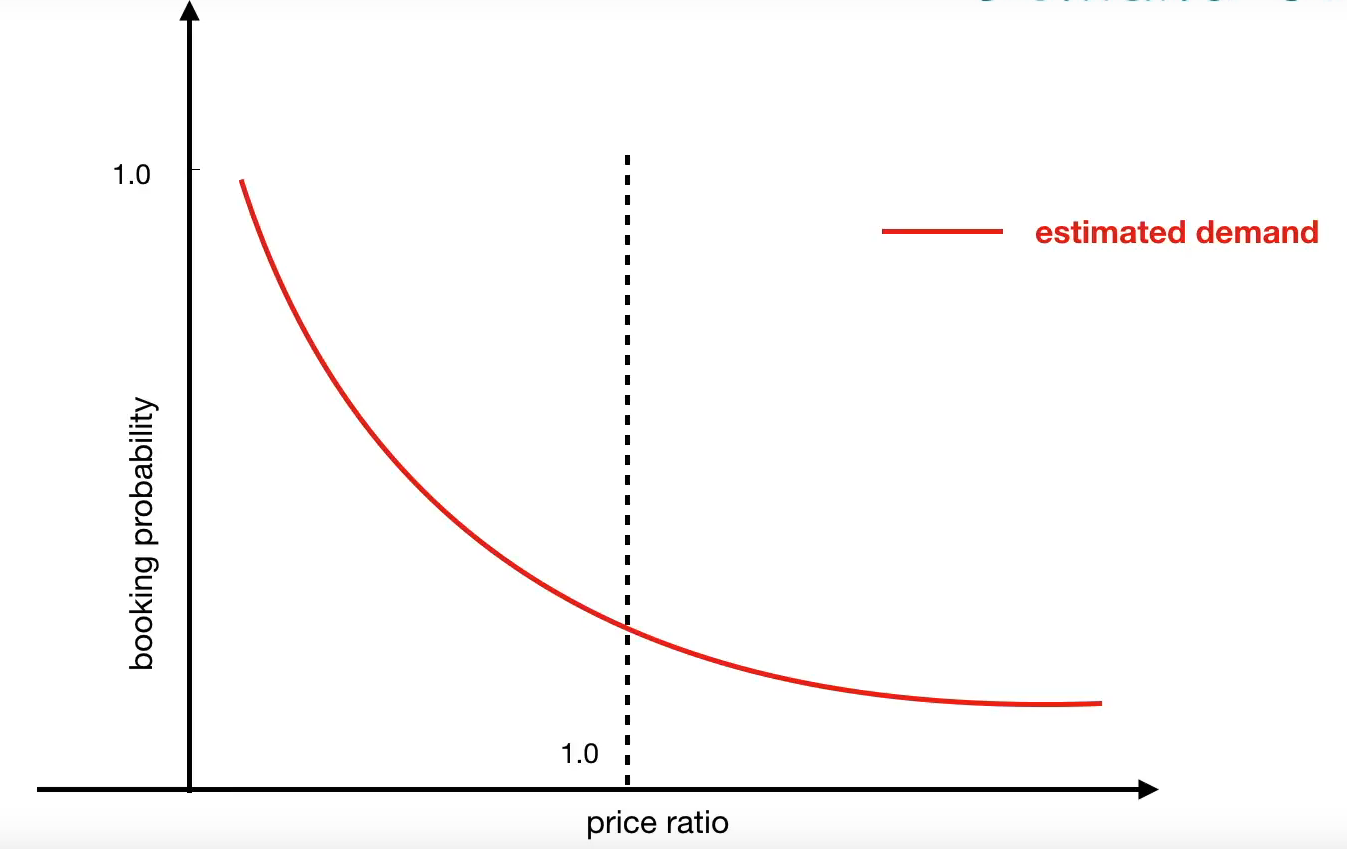

In [1]:
from IPython.display import Image
Image("./demond curve.jpg")

Ideally, a proper dynamic pricing system will have the following three components:
### • Binary classification model - booking probability model
Predicts the booking probability of each room-night.
### • Pricing model
Predicts the optimal price for each hotel/room-night based on the result of the first model. 
### • Personalization 
Adjust the price on top of the output from the second model to generate the final price suggestions.

## Challenge 
It is normally hard to estimate demand curve because of the sparseness of data. Hotels do not change prices dramatically. As a result, we do not have observations of the price points that are far away from the base price. Therefore, for the pricing model, we normally do not use the optimization based on the aforementioned demand curve to suggest the optimal price. An alternative solution is to build a regression model to adjust the base price set by the hotel based on the booking probability generated by the booking probability model.


##### Since  time is limited, I will focus on the first model, which I believe is the foundament of the whole system and will share some ideas on the second model during F2F.

# <center> Booking probability model

## 1. Features are used in this model
 #### • Hotel requirement features
 Hotel features, room price per night, person capacity, etc.
 #### • Temporal features
 Seasonality (day of the year, day of the week), time between check in and check out, lead time
 #### • Local demand feautres
 Number of available rooms in the neighborhood, room views. 

## 2. Challenges of this task
#### • Imbalanced data
In this case, ratio of bookings vs non-bookings is around 7:1000. And size of minority class is 309 observation so it is not possible to train an advanced model. 
Therefore, I used rule-based data augmentation to generate more minority samples. I also tried training the model using class-weights.
#### • Several Markets
It's reasonable to assume that the market or area with higher demand for hotels will have higher hotel prices. Therefore, the best strategy is to train a model for each market or area.

# <center>Code

## Preliminary analysis

In [1]:
from __future__ import division
import numpy as np
import pandas as pd 
# import math
from collections import Counter
df = pd.read_csv('./e_test.csv')
df.head()

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,hotel_feature_2,hotel_feature_3,hotel_feature_4,hotel_feature_5,booked,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,20150126,20160402,20160416,3,2,0,517,1724.38,0,64.490309,85.0,7,0,0,0,NaN,NaN,NaN
1,20150126,20160402,20160416,3,2,0,517,1724.38,0,64.490309,85.0,7,0,0,0,NaN,NaN,NaN
2,20150126,20160402,20160416,3,2,0,29771,1905.54,1,25.826343,52.0,13,1,1,0,NaN,NaN,NaN
3,20150126,20160403,20160408,2,0,1,517,2077.95,0,64.490309,85.0,9,0,0,0,NaN,NaN,NaN
4,20150126,20160403,20160408,2,0,1,40744,6822.10,0,24.959968,52.0,11,1,2,0,NaN,NaN,NaN


In [2]:
df.describe()

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,hotel_feature_2,hotel_feature_3,hotel_feature_4,hotel_feature_5,booked,Unnamed: 15,Unnamed: 16,Unnamed: 17
count,4.664900e+04,4.664900e+04,4.664900e+04,46649.000000,46649.000000,46649.000000,46649.000000,46649.000000,46649.000000,45447.000000,46324.000000,46649.000000,46649.000000,46649.000000,46649.000000,0.0,0.0,0.0
mean,2.015011e+07,2.015055e+07,2.015059e+07,2.370555,0.812322,5509.415593,23095.173787,2598.923857,0.501468,76.849181,63.109598,59.071256,5.982315,2.357521,0.006624,NaN,NaN,NaN
std,7.336832e+00,8.698793e+02,9.527680e+02,0.912651,0.949211,4460.736102,13480.380598,4490.042057,0.500003,41.747154,22.846002,51.380975,6.014717,1.811254,0.081118,NaN,NaN,NaN
min,2.015010e+07,2.015010e+07,2.015010e+07,1.000000,0.000000,0.000000,1.000000,-1058.820000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,2.015011e+07,2.015022e+07,2.015022e+07,2.000000,0.000000,1656.000000,11474.000000,559.400000,0.000000,46.238512,52.000000,16.000000,1.000000,1.000000,0.000000,NaN,NaN,NaN
50%,2.015011e+07,2.015042e+07,2.015043e+07,2.000000,0.000000,4488.000000,23309.000000,1336.580000,1.000000,67.712628,52.000000,46.000000,4.000000,1.000000,0.000000,NaN,NaN,NaN
75%,2.015012e+07,2.015071e+07,2.015072e+07,3.000000,2.000000,8727.000000,33668.000000,3090.510000,1.000000,128.117134,90.000000,86.000000,9.000000,4.000000,0.000000,NaN,NaN,NaN
max,2.015013e+07,2.016051e+07,2.016052e+07,8.000000,6.000000,16015.000000,46647.000000,175454.410000,1.000000,143.777606,100.000000,287.000000,36.000000,7.000000,1.000000,NaN,NaN,NaN


In [3]:
# remove negative hotel price
df['hotel_price'] = abs(df['hotel_price'] )

In [4]:
# drop the unwanted columns
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17'])
# drop the rows that have hotel_feature1 or hotel_feature2 equal to NA
df = df.dropna()

In [5]:
print('Number of unique hotels after cleansing:', len(df.groupby('hotel_id').size()))

Number of unique hotels after cleansing: 344


In [6]:
# viewing data balance
c = Counter(df['booked'])
print('Number of total non-bookings: {}'.format(c[0]))
print('Number of total bookings: {}'.format(c[1]))

Number of total non-bookings: 44822
Number of total bookings: 300


## Generating temporal features

In [7]:
df['search_date'] = pd.to_datetime(df['search_date'], format='%Y%m%d')
df['arrival'] = pd.to_datetime(df['arrival'], format='%Y%m%d')
df['departure'] = pd.to_datetime(df['departure'], format='%Y%m%d')
# create a new column: year_month
# df['y_m'] = df['arrival'].dt.year.astype(str) + df['arrival'].dt.month.astype(str).str.zfill(2)
df['y_m'] = df['arrival'].dt.to_period('M')
# create a new column: day of week
df['day_of_week'] = df['arrival'].dt.dayofweek
# create a new column: day of year
df['day_of_year'] = df['arrival'].dt.dayofyear
# create a new column: lead time
df['lead_time'] = (df['arrival'] - df['search_date']).dt.days
# create a new column: num of nights
df['num_nights'] = (df['departure'] - df['arrival']).dt.days
# create a new column: price per night
df['price'] = round((df['hotel_price']/df['num_nights']),2)
# create a new column: year
df['year'] = df['arrival'].dt.year

In [8]:
df.head()

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,...,hotel_feature_4,hotel_feature_5,booked,y_m,day_of_week,day_of_year,lead_time,num_nights,price,year
0,2015-01-26,2016-04-02,2016-04-16,3,2,0,517,1724.38,0,64.490309,...,0,0,0,2016-04,5,93,432,14,123.17,2016
1,2015-01-26,2016-04-02,2016-04-16,3,2,0,517,1724.38,0,64.490309,...,0,0,0,2016-04,5,93,432,14,123.17,2016
2,2015-01-26,2016-04-02,2016-04-16,3,2,0,29771,1905.54,1,25.826343,...,1,1,0,2016-04,5,93,432,14,136.11,2016
3,2015-01-26,2016-04-03,2016-04-08,2,0,1,517,2077.95,0,64.490309,...,0,0,0,2016-04,6,94,433,5,415.59,2016
4,2015-01-26,2016-04-03,2016-04-08,2,0,1,40744,6822.10,0,24.959968,...,1,2,0,2016-04,6,94,433,5,1364.42,2016


### Data Augmentation
Since the number of booking samples is small, I am trying to split a multi-nights booking into serveral single-night bookings. It is also good for the following analysis as it is better to descirbe the actual demand on each date.

In [9]:
# Generate more booking samples (booked = 1) by splitting number of staying nights into serveral single-night bookings
from datetime import timedelta, date
import random
newlist = []
# newDF = pd.DataFrame(columns = df.columns)
for index, row in df.iterrows():
#     if row['booked'] == 1:
        for n in range(0, int(row['num_nights'])):
            new_row = row.copy()
            new_row['arrival'] = row['arrival'] + timedelta(n)
            new_row['y_m'] = new_row['arrival'].to_period('M')
#             new_row['y_m'] =str(new_row['arrival'].year) + str(new_row['arrival'].month).zfill(2)
            new_row['day_of_week'] = new_row['arrival'].dayofweek
            new_row['day_of_year'] = new_row['arrival'].dayofyear
            new_row['lead_time'] = (new_row['arrival'] - new_row['search_date']).days
            new_row['num_nights'] = 1
            new_row['year'] = new_row['arrival'].year
            newlist.append(new_row.values)
#             newDF = newDF.append(new_row, ignore_index=True)  
df_large = pd.DataFrame(newlist, columns = df.columns)
# df_large = df.append(newDF, ignore_index=True)
df_large['booked'] = df_large['booked'].astype(int)  

### Day of year

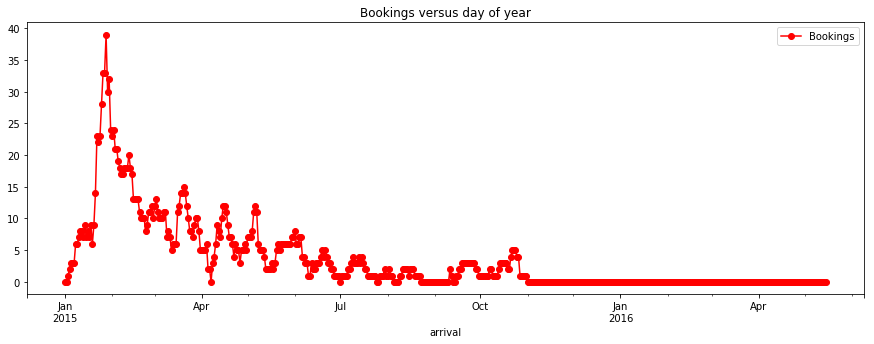

In [11]:
# Plot number of bookings
yearday_book  = df_large.groupby('arrival')["booked"].sum()
yearday_book.plot(legend=True, color= 'r', marker='o',title="Bookings",label = 'Bookings',figsize=(15,5)) 

In [12]:
# remove data for 2016
df_large = df_large[df_large.year != 2016]

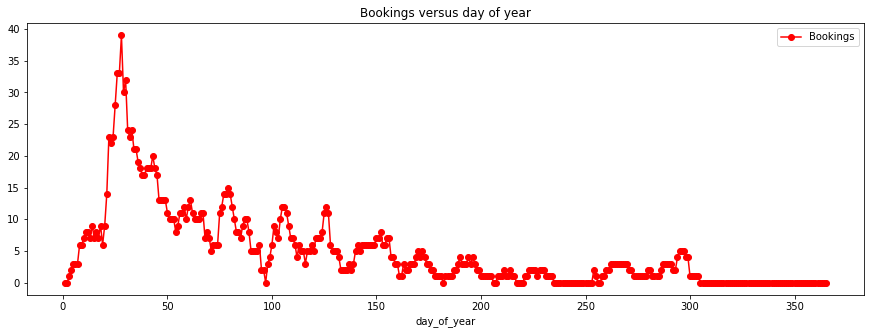

In [18]:
# Plot number of bookings versus day of year
yearday_book  = df_large.groupby('day_of_year')["booked"].sum()
yearday_book.plot(legend=True, color= 'r', marker='o',title="Bookings versus day of year",label = 'Bookings',figsize=(15,5)) 

Since in this dataset, all the search were made in January, therefore we can see there is a peak of booking in the Feburary.

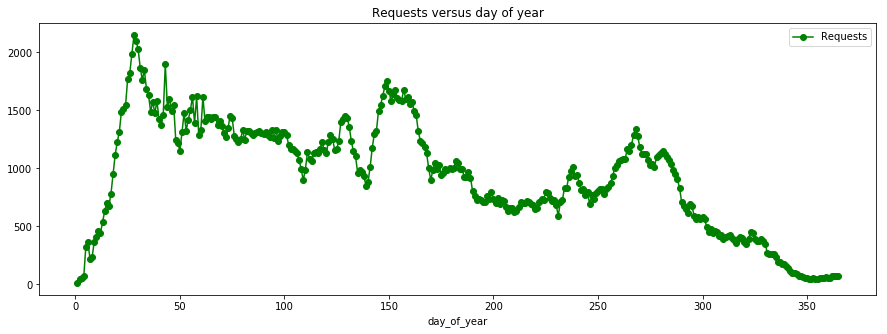

In [19]:
# Plot number of requests versus day of year
yearday_request  = df_large.groupby('day_of_year')["num_nights"].sum()
yearday_request.plot(legend=True, color= 'g', marker='o',title="Requests versus day of year",label = 'Requests',figsize=(15,5)) 

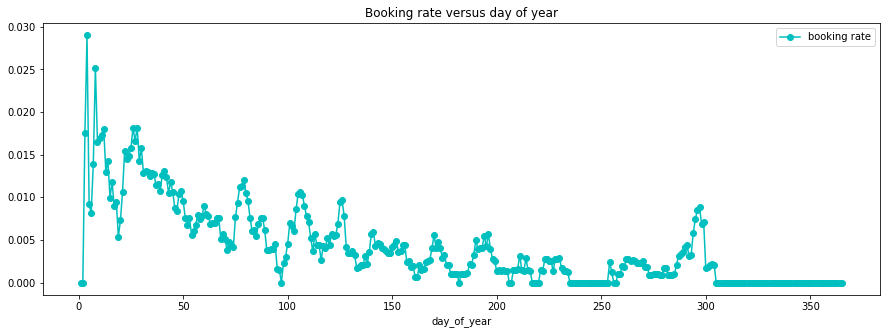

In [20]:
yearday_rate = yearday_book/yearday_request
yearday_rate.plot(legend=True, color= 'c', marker='o',title="Booking rate versus day of year",label = 'booking rate',figsize=(15,5)) 

### Day of week

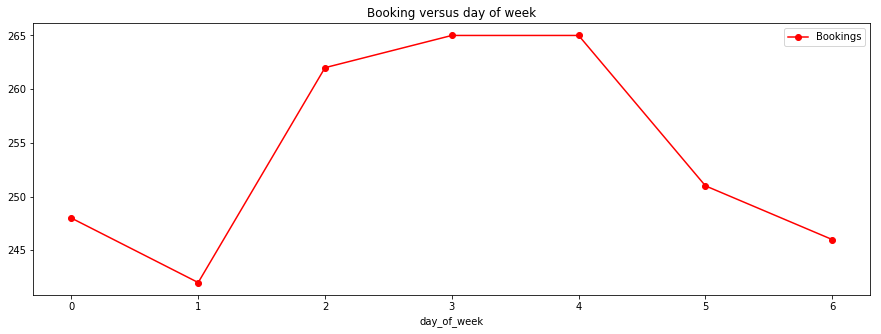

In [21]:
# Plot number of bookings versus day of week
weekday_book  = df_large.groupby('day_of_week')["booked"].sum()
weekday_book.plot(legend=True, color= 'r', marker='o',title="Booking versus day of week",label = 'Bookings',figsize=(15,5)) 

Thursday and Friday have a little bit more bookings.

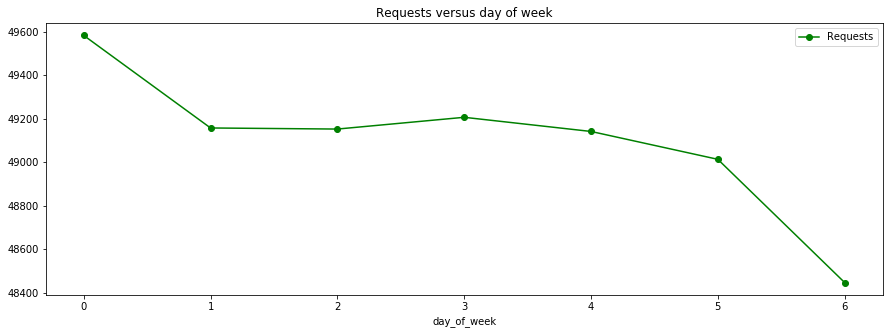

In [23]:
# Plot number of requests versus day of week
weekday_request  = df_large.groupby('day_of_week')["num_nights"].sum()
weekday_request.plot(legend=True, color= 'g', marker='o',title="Requests versus day of week",label = 'Requests',figsize=(15,5)) 

Monday has a little bit more requests.

### Lead time

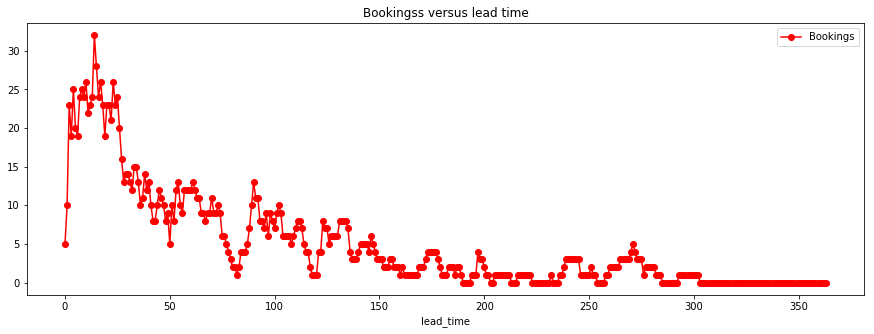

In [24]:
# Plot number of requests versus day of week
leadtime_book  = df_large.groupby('lead_time')["booked"].sum()
leadtime_book.plot(legend=True, color= 'r', marker='o',title="Bookingss versus lead time",label = 'Bookings',figsize=(15,5)) 

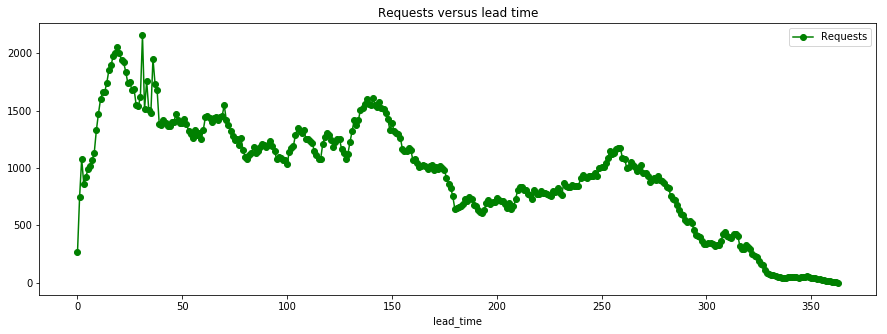

In [25]:
# Plot number of requests versus day of week
leadtime_request  = df_large.groupby('lead_time')["num_nights"].sum()
leadtime_request.plot(legend=True, color= 'g', marker='o',title="Requests versus lead time",label = 'Requests',figsize=(15,5)) 

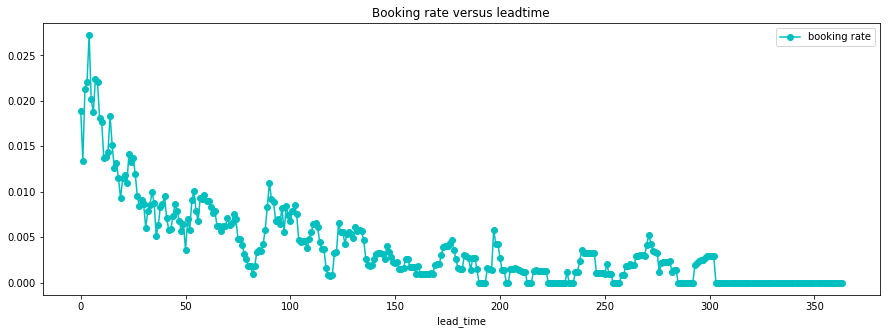

In [27]:
leadtime_rate = leadtime_book/leadtime_request
leadtime_rate.plot(legend=True, color= 'c', marker='o',title="Booking rate versus leadtime",label = 'booking rate',figsize=(15,5)) 

In [28]:
df_large.to_csv('t1.csv', index = False)

## Generating local demand features
1. Since I don't know what is the actual meaning of hotel_feature_1-5, I beleive they can jointly describe the area of a hotel or the market of a hotel. 
2. I am trying to cluster them as I believe the suggested price should be based on the location or market.

### K-means Clustering 

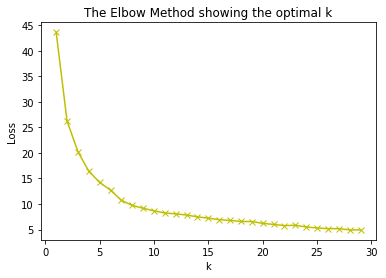

In [30]:
# Hotel clustering based on K-means 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.spatial.distance import cdist
hotel_feature_unique = df.iloc[:, [9,10,12,13]] #.drop_duplicates()  # get rid of hotel_feautre3 as I guess it is used to describe room type
hotel_feature_all = df_large.iloc[:, [9,10,12,13]].values
loss = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hotel_feature_unique)
    loss.append(sum(np.min(cdist(hotel_feature_unique, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hotel_feature_unique.shape[0])
# Plot the Loss
plt.plot(K, loss, 'yx-')
plt.xlabel('k')
plt.ylabel('Loss')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Use Elbow method to choose the number of clusters

In [31]:
# According to Elbow method, choose k = 7 
kmeanModel = KMeans(n_clusters=7).fit(hotel_feature_unique)
clusters = kmeanModel.predict(hotel_feature_all)
df_large['clusters'] = clusters

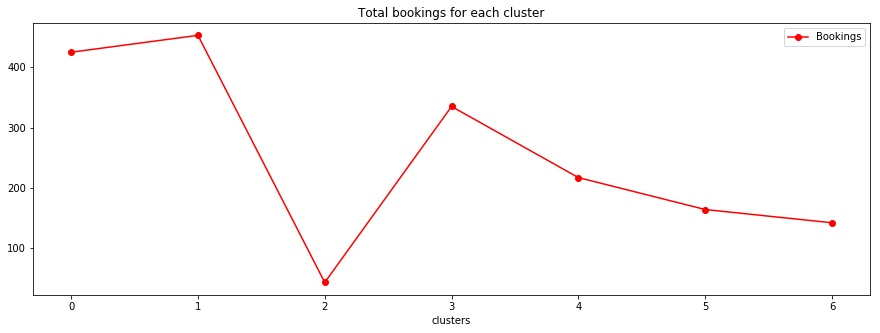

In [32]:
# Plot number of total bookings in the corresponding cluster.
cluster_book  = df_large.groupby('clusters')["booked"].sum()
cluster_book.plot(legend=True, color= 'r', marker='o', title="Total bookings for each cluster",label = 'Bookings',figsize=(15,5)) 

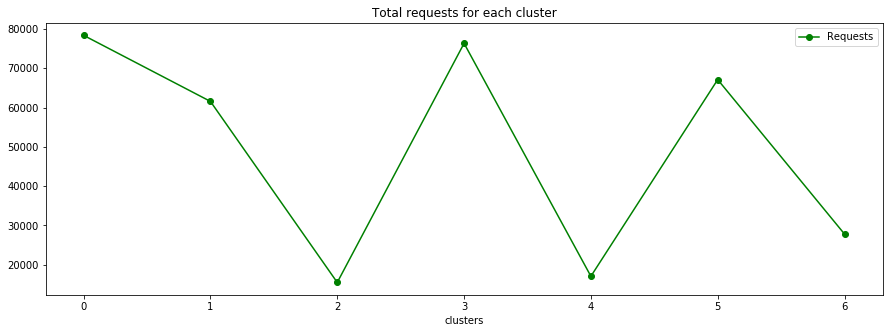

In [33]:
# Plot number of total requests in the corresponding cluster.
cluster_request  = df_large.groupby('clusters')["num_nights"].sum()
cluster_request.plot(legend=True, color= 'g', marker='o', title="Total requests for each cluster",label = 'Requests',figsize=(15,5)) 

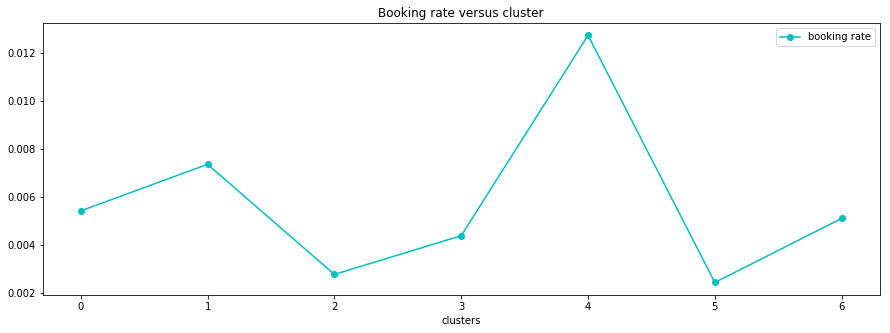

In [36]:
cluster_rate = cluster_book/cluster_request
cluster_rate.plot(legend=True, color= 'c', marker='o',title="Booking rate versus cluster",label = 'booking rate',figsize=(15,5)) 

In [38]:
# add another column to descibe the request in the area/market 
df_tmp1 = df_large.groupby(['day_of_year','clusters'], as_index=False)["num_nights"].sum()
df_tmp1 = df_tmp1.rename(columns={'num_nights': 'requests in the area/market'})
df_large = pd.merge(df_large, df_tmp1, on=['day_of_year','clusters'], how='left')
# add another column to descibe the book in the area/market 
df_tmp2 = df_large.groupby(['day_of_year','clusters'], as_index=False)["booked"].sum()
df_tmp2 = df_tmp2.rename(columns={'booked': 'books in the area/market'})
df_large = pd.merge(df_large, df_tmp2, on=['day_of_year','clusters'], how='left')
# add another column to descibe the booking rate in the area/market 
df_large['booking rate in the area/market'] = df_large['books in the area/market']/ df_large['requests in the area/market']

In [39]:
df_large.to_csv('t1.csv', index = False)

In [40]:
df_large.head()

,search_date,arrival,departure,num_adults,num_children,search_id,hotel_id,hotel_price,is_promo,hotel_feature_1,...,day_of_week,day_of_year,lead_time,num_nights,price,year,clusters,requests in the area/market,books in the area/market,booking rate in the area/market
0,2015-01-05,2015-09-20,2015-09-30,2,1,3,517,3705.14,0,64.490309,...,6,263,258,1,370.51,2015,3,237,1,0.004219
1,2015-01-05,2015-09-21,2015-09-30,2,1,3,517,3705.14,0,64.490309,...,0,264,259,1,370.51,2015,3,247,1,0.004049
2,2015-01-05,2015-09-22,2015-09-30,2,1,3,517,3705.14,0,64.490309,...,1,265,260,1,370.51,2015,3,262,1,0.003817
3,2015-01-05,2015-09-23,2015-09-30,2,1,3,517,3705.14,0,64.490309,...,2,266,261,1,370.51,2015,3,279,1,0.003584
4,2015-01-05,2015-09-24,2015-09-30,2,1,3,517,3705.14,0,64.490309,...,3,267,262,1,370.51,2015,3,281,1,0.003559


# Train-Test splitting & Under-sampling
1. The data is imbalanced, so I under-sample the majority class to get the balance.
2. Split the data into training and testing with a 70/30 split. (Validation part is involved in the following cross-vlaidation) 

In [41]:
from sklearn import ensemble
from sklearn.utils import class_weight
X = df_large.iloc[:, [3,4,9,10,11,12,13,16,17,18,20,22,25]].values #[num_adults,num_children,is_promo,hotel_feature_1-5,day_of_week,day_of_year,lead_time,price,clusters,booking rate in the area/market]
y = df_large.iloc[:, 14].values # booked

from imblearn.under_sampling import RandomUnderSampler
print('Original dataset shape: {}'.format(Counter(y)))
# data balancing
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_sample(X, y)
print('Resampled dataset shape: {}'.format(Counter(y)))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)
# class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print('Training set Shape:', X_train.shape)
print('Testing set Shape:', X_test.shape)

Original dataset shape: Counter({0: 341919, 1: 1779})
Resampled dataset shape: Counter({0: 1779, 1: 1779})
Training set Shape: (2490, 13)
Testing set Shape: (1068, 13)


# Training & Validation
1. I am going to train 2 models, which are Random Forest and Gradient Boosting Machine. 
2. The Grid Search with 3-folds Cross Validation is then used to choose the best hyperparameters.

### Random Forest

In [42]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid  
param_grid_rf = {
    'bootstrap': [True, False],
    'max_depth': [5, 10, 20],
    'max_features': [2, 5, 8],
#     'min_samples_leaf': [3, 5],
    'min_samples_split': [5, 8, 11],
    'n_estimators': [100, 300, 500]
}
# Create a base model
rf = ensemble.RandomForestClassifier(random_state = 42)
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid_rf, cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  5.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True, False], 'max_depth': [5, 10, 20], 'max_features': [2, 5, 8], 'min_samples_split': [5, 8, 11], 'n_estimators': [100, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [43]:
grid_search_rf.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 2,
 'min_samples_split': 5,
 'n_estimators': 500}

### Gradient Boosting Machine

In [44]:
# Create the parameter grid  
param_grid_gbm = {
    'learning_rate': [0.1, 0.03],
    'max_depth': [5, 10, 20],
    'max_features': [2, 5, 8],
#     'min_samples_leaf': [3, 5],
    'min_samples_split': [5, 8, 11],
    'n_estimators': [100, 300, 500]
}
# Create a base model
gbm = ensemble.GradientBoostingClassifier(random_state = 42)
# Instantiate the grid search model
grid_search_gbm = GridSearchCV(estimator = gbm, param_grid = param_grid_gbm, cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search_gbm.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed:  7.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.1, 0.03], 'max_depth': [5, 10, 20], 'max_features': [2, 5, 8], 'min_samples_split': [5, 8, 11], 'n_estimators': [100, 300, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [45]:
grid_search_gbm.best_params_

{'learning_rate': 0.03,
 'max_depth': 20,
 'max_features': 2,
 'min_samples_split': 5,
 'n_estimators': 300}

# Performance Evaluation
1. Compare the performance of Random Forest and Gradient Boosting Machine by using ROC & AUC and PRC & F1-score. 
2. My experimental results show that <font color='red'> GBM has a slightly better performance</font> .

In [46]:
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_recall_curve, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
#rf
clf_rf = grid_search_rf.best_estimator_
y_pred_rf = clf_rf.predict_proba(X_test)[:,1]
y_pred1_rf = clf_rf.predict(X_test)
#gbm
clf_gbm = grid_search_gbm.best_estimator_
y_pred_gbm = clf_gbm.predict_proba(X_test)[:,1]
y_pred1_gbm = clf_gbm.predict(X_test)

### ROC curve & AUC

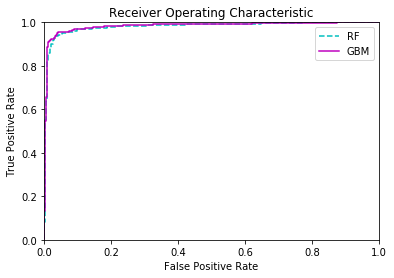

RF AUC:0.9816113005768179
GBM AUC:0.984049794394622
RF Feature importance:[ 0.02917233  0.03516086  0.08291616  0.04359201  0.09576355  0.04799192
  0.02978478  0.01324325  0.10316702  0.11605648  0.10164451  0.02353581
  0.27797132]
GBM Feature importance:[ 0.0316804   0.03666322  0.08215893  0.03825267  0.14383831  0.04738602
  0.03152945  0.02380911  0.10235344  0.11983079  0.14162856  0.02415624
  0.17671285]


In [47]:
#rf
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf)
#gbm
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_gbm)
auc_gbm = roc_auc_score(y_test, y_pred_gbm)
#ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf, tpr_rf, 'c--', label = 'RF')
plt.plot(fpr_gbm, tpr_gbm, 'm-', label = 'GBM')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='upper right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()
print('RF AUC:{}'.format(auc_rf))
print('GBM AUC:{}'.format(auc_gbm))
print('RF Feature importance:{}'.format(clf_rf.feature_importances_))
print('GBM Feature importance:{}'.format(clf_gbm.feature_importances_))

### PR curve & F1 score

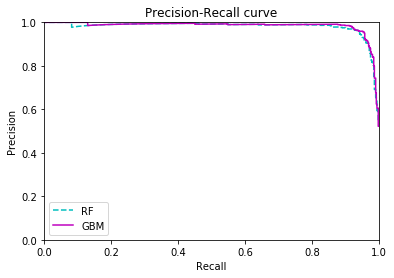

RF F1-score:0.933579335793358
GBM F1-score:0.9344413665743305


In [48]:
#rf
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_rf)
f1score_rf = f1_score(y_test, y_pred1_rf)
#gbm
precision_gbm, recall_gbm, _ = precision_recall_curve(y_test, y_pred_gbm)
f1score_gbm = f1_score(y_test, y_pred1_gbm)
# PR curve
plt.plot(recall_rf, precision_rf, 'c--', label = 'RF')
plt.plot(recall_gbm, precision_gbm, 'm-', label = 'GBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.show()
print('RF F1-score:{}'.format(f1score_rf))
print('GBM F1-score:{}'.format(f1score_gbm))

# <center> Future Work
### Pricing model
Based on the aforementioned booking probability model, we can build a pricing model which maps input features to price suggestions. There are some assumptions:
1. For the same hotel, suggested price is positively correlated with the booking probability at current price. This is to ensure that our price suggestions are responsive to changes in booking probability.
2. Price suggestions are centered around the most representative price that is often set by the hotel, with learnable increasing/decreasing magnitudes.
3. Additional demand signals that are not fully captured by the booking probability model should be easily plugged in.

The price suggestion $P_s$ is given by
$$P_s = P · V$$
where $V$ the increase/decrease magnitude, which is based on the demand score $D$ and the booking probability $q$: 
$$ V =\left\{
\begin{array}{rcl}
1 + \theta_1(q^{\phi_H^{-q^D}}-\theta_2)      &      & {if D>0,}\\
1 + \theta_1(q^{\phi_L^{-(1-q)^D}}-\theta_2)     &      & if {D\leq0;}
\end{array} \right. $$

where $\theta$ and $\phi$ are the parameters that we can learn from the historical data.

# <center> Thank you 
Thank you for spending time on reviewing this. If you have any questions, please let me know. My email is rayli.ryan@gmail.com.